# Model Training

### Gaussian Mixture Model

In [12]:
# Import necessary libraries
import torch
import pickle
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fcmeans import FCM
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [13]:
# Load the processed data
df = pd.read_csv('data/model_data.csv')

In [14]:
# Use pretrained model BERT to transform the words
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = bert_model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_embedding)
    return np.vstack(embeddings)

X_bert = get_bert_embeddings(df['article'].tolist())
X_scaled = StandardScaler().fit_transform(X_bert)

# Use PCA to reduce dimension into 50
pca = TruncatedSVD(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Use UMAP to reduce the dimension into 2 for visualization purpose
reducer = UMAP(n_neighbors=15, n_components=2, min_dist=0.3, metric='cosine', random_state=42)
X = reducer.fit_transform(X_pca)

c:\Users\User\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


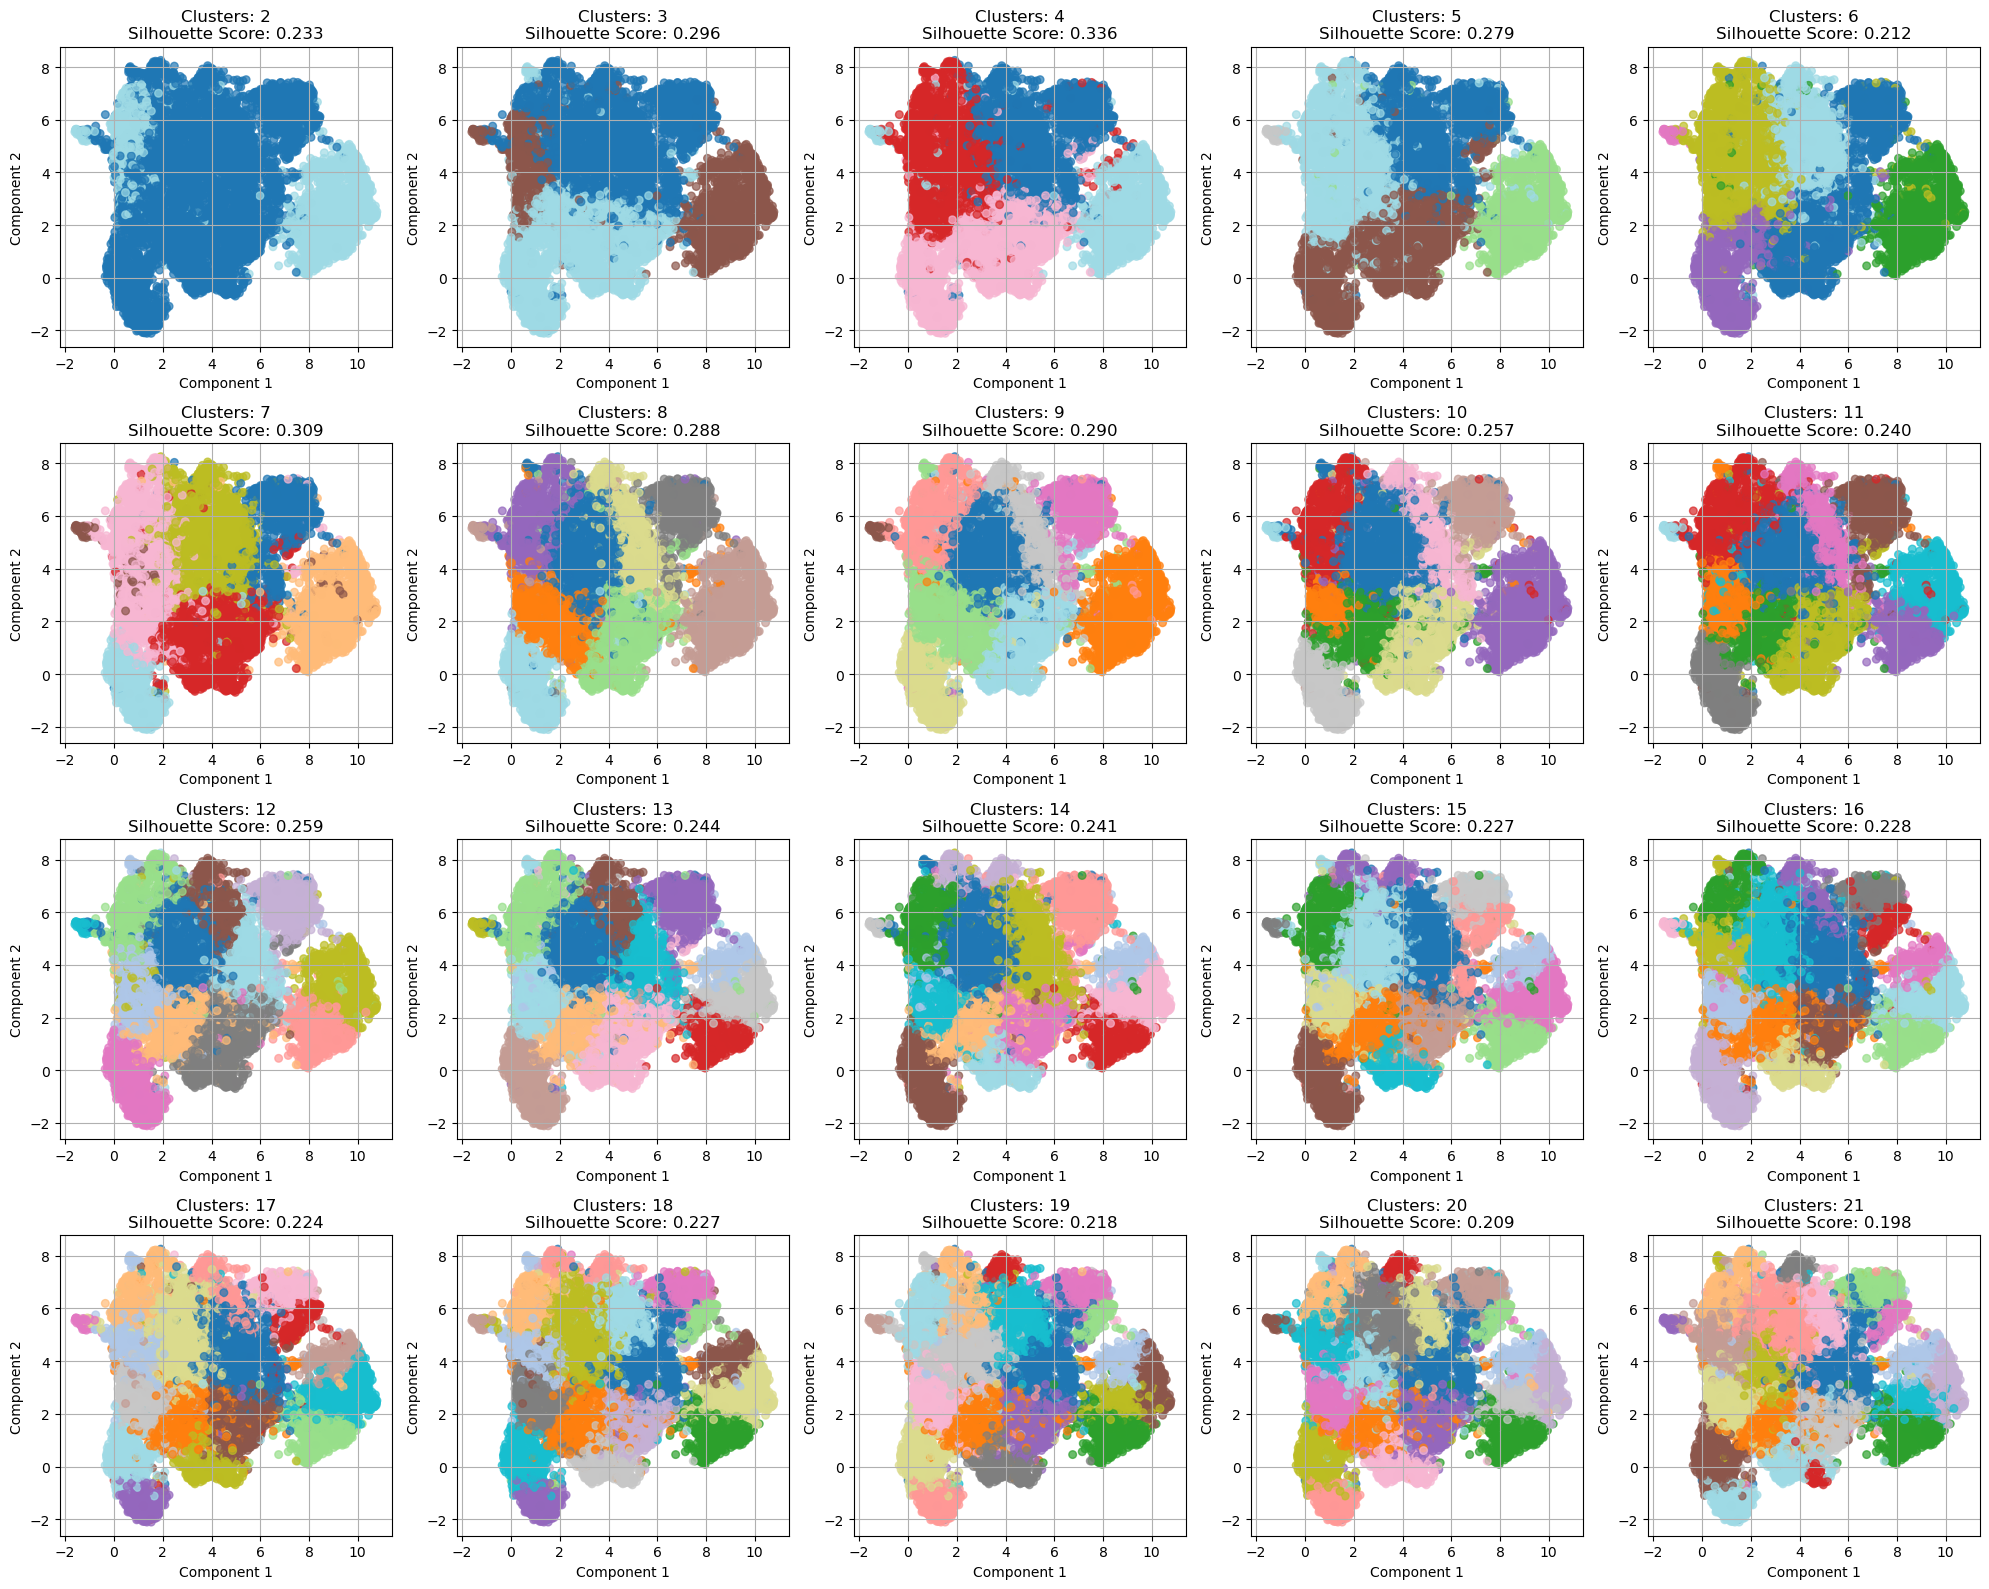

In [15]:
# Range of cluster numbers (from 2 to 21)
cluster_range = range(2, 22)

# Plot settings
n_cols = 5
n_rows = int(np.ceil(len(cluster_range) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axs = axs.flatten()

for i, k in enumerate(cluster_range):
    gmm = GaussianMixture(n_components=k, random_state=42)
    clusters = gmm.fit_predict(X_umap)

    df['Cluster'] = clusters
        
    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(X, clusters)
    
    # Plot the clusters
    ax = axs[i]
    scatter = ax.scatter(X[:, 0], X[:, 1], 
                         c=clusters, cmap='tab20', s=30, alpha=0.7)
    ax.set_title(f"Clusters: {k}\nSilhouette Score: {silhouette_avg:.3f}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.grid(True)

# Remove extra axes if any
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()
